# setup kaggle requirements

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"romanyn36","key":"0273280af48cbf5753443b7cb64808be"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


# download Dataset in Colab 

In [5]:
#download datset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.28G/2.29G [00:24<00:00, 102MB/s]
100% 2.29G/2.29G [00:24<00:00, 99.0MB/s]


In [6]:
#unzip dataset
import zipfile

with zipfile.ZipFile('/content/chest-xray-pneumonia.zip', 'r') as zip_ref:
      zip_ref.extractall('/content/chest-xray-pneumonia')
  

In [ ]:
%ls /content/chest-xray-pneumonia/chest_xray

chest_xray/  __MACOSX/  test/  train/  val/


# import Libraries 

In [7]:
import tensorflow as tf
import keras
from keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,Flatten
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils import to_categorical
import os
from tqdm import tqdm
import cv2
import random
import pickle as pk
from sklearn.model_selection import train_test_split
import numpy as np 
import pandas as pd 
from keras.models import load_model
from keras.layers import BatchNormalization

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from keras import regularizers

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import keras
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix



# Constants

In [8]:
#define constants
imges_num=5000
class_num=10
FAST_RUN = False
IMAGE_WIDTH=220
IMAGE_HEIGHT=220
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# training 

In [9]:
# trainingPath="/content/kermany2018/OCT2017 /train"

trainingPath="/content/chest-xray-pneumonia/chest_xray/train"
categories=os.listdir(trainingPath)
categories

['NORMAL', 'PNEUMONIA']

In [10]:
#save class names in dictionary 

classnames={}
for i in range(2):
  classnames[i]=categories[i]
classnames

{0: 'NORMAL', 1: 'PNEUMONIA'}

In [11]:
#load the images and read it and save eacah image with folder name [class name]

training =[]
x=0
for category in categories:
    folder=os.path.join(trainingPath,category)
    # print(folder)
    x2=0 
    for file in tqdm(os.listdir(folder)):
        # print(file)
        try:
            img=cv2.imread(os.path.join(folder,file))
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img=cv2.resize(img,IMAGE_SIZE)# size image for CNN input
            classNum=categories.index(category) #detrmine class
            training.append([img,classNum])
            # plt.imshow(img)
            # plt.show()
        except Exception as e:
            pass
        
        if x2>=imges_num:
            break
        x2+=1
    
    if x>=class_num-1:    
        break
    x+=1

100%|██████████| 3875/3875 [00:34<00:00, 112.86it/s]


In [12]:
len(training)

5216

In [13]:
#shuffle my data to avoid overfitting 

training[0]
random.shuffle(training)
for trainSample in training[:10]:
    print(trainSample[1])

1
1
0
1
1
1
1
1
1
1


In [14]:
#split features and labels 

x_train_data=[]
y_train_data=[]
for feature,label in training:
    x_train_data.append(feature)
    y_train_data.append(label)
    

In [15]:
#convert my data to nunpy array

x_train_data=np.array(x_train_data)
y_train_data=np.array(y_train_data)

In [16]:
#reshape data to RGB form #3 channels with 220*220 

x_train_data=x_train_data.reshape(-1,IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNELS)
print(x_train_data.shape)
print(y_train_data.shape)

(5216, 220, 220, 3)
(5216,)


# test data


In [18]:
testPath="/content/chest-xray-pneumonia/chest_xray/test"
categories=os.listdir(trainingPath)
categories

['NORMAL', 'PNEUMONIA']

In [19]:
#load the images and read it and save eacah image with folder name [class name]

test =[]
x=0

for category in categories:
    folder=os.path.join(testPath,category)
    # print(folder)
    x2=0 
    for file in tqdm(os.listdir(folder)):
        # print(file)
        try:
            img=cv2.imread(os.path.join(folder,file))
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img=cv2.resize(img,IMAGE_SIZE)# size image for CNN input
            classNum=categories.index(category) #detrmine class
            test.append([img,classNum])
            # plt.imshow(img)
            # plt.show()
        except Exception as e:
            pass
        
        if x2>imges_num:
            break
        x2+=1
    
    if x>=class_num-1:    
        break
    x+=1
    # print(x)

100%|██████████| 390/390 [00:02<00:00, 150.35it/s]


In [20]:
#shuffle my data to avoid overfitting 

random.shuffle(test)
for trainSample in test[:10]:
    print(trainSample[1])

1
1
1
1
1
1
1
1
1
1


In [21]:
#split features and labels 

x_test=[]
y_test=[]
for feature,label in test:
    x_test.append(feature)
    y_test.append(label)

In [22]:
#convert my data to nunpy array

x_test=np.array(x_test)
y_test=np.array(y_test)

In [23]:
#reshape data to RGB form 3 channels with 220*220 

x_test=x_test.reshape(-1,IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNELS)

print(x_test.shape)
print(y_test.shape)

(624, 220, 220, 3)
(624,)


# split data

In [24]:
#split the train data into train and validation

# x_train=x_train_data
# y_train=y_train_data

x_train,x_validation_data,y_train,y_validation_data=train_test_split(x_train_data,y_train_data,test_size=0.15,random_state=36)
print(x_train.shape)
print(y_train.shape)

print(x_validation_data.shape)
print(y_validation_data.shape)

print(x_test.shape)
print(y_test.shape)

(4433, 220, 220, 3)
(4433,)
(783, 220, 220, 3)
(783,)
(624, 220, 220, 3)
(624,)


# shapes of data

In [25]:
print(f'x_train shape :         {x_train.shape}')
print(f'y_train shape :         {y_train.shape}\n')

print(f'x_validation shape :    {x_validation_data.shape}')
print(f'y_validation shape :    {y_validation_data.shape}\n')

print(f'x_test shape :          {x_test.shape}')
print(f'x_test shape :          {y_test.shape}')


x_train shape :         (4433, 220, 220, 3)
y_train shape :         (4433,)

x_validation shape :    (783, 220, 220, 3)
y_validation shape :    (783,)

x_test shape :          (624, 220, 220, 3)
x_test shape :          (624,)


# normalization 

In [26]:
# x_train_data=x_train.astype('float')
# x_train_data=x_train/255.0

# x_test=x_test.astype('float')
# x_test=x_test/255.0

# Build Model

In [31]:
model=keras.models.Sequential()

model.add(Conv2D(16,(3,3),input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

In [32]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 218, 218, 16)      448       
                                                                 
 batch_normalization_3 (Batc  (None, 218, 218, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 109, 109, 16)     0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 109, 109, 16)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 107, 107, 64)      9280      
                                                                 
 batch_normalization_4 (Batc  (None, 107, 107, 64)    

In [61]:
history=model.fit(x_train,y_train,epochs=4,validation_data=(x_validation_data, y_validation_data))

Epoch 1/4
139/139 [==============================] - 11s 76ms/step - loss: 0.0624 - accuracy: 0.9792 - val_loss: 0.3092 - val_accuracy: 0.9298
Epoch 2/4
139/139 [==============================] - 10s 75ms/step - loss: 0.0571 - accuracy: 0.9777 - val_loss: 0.2179 - val_accuracy: 0.9323
Epoch 3/4
139/139 [==============================] - 10s 75ms/step - loss: 0.0447 - accuracy: 0.9826 - val_loss: 0.1859 - val_accuracy: 0.9400
Epoch 4/4
139/139 [==============================] - 10s 74ms/step - loss: 0.0327 - accuracy: 0.9878 - val_loss: 0.3575 - val_accuracy: 0.9349


In [41]:
model = load_model('/content/drive/MyDrive/xray_model/xRay_model_binary 2 8.h5')

# Confusion Matrix

In [42]:
# Generate predictions on test data
y_pred = model.predict(x_test)
y_pred_binary = np.squeeze(np.round(y_pred))
# Generate confusion matrix
confusion_Matrix = confusion_matrix(y_test, y_pred_binary)
confusion_Matrix

20/20 [==============================] - 1s 19ms/step


array([[180,  54],
       [ 23, 367]])

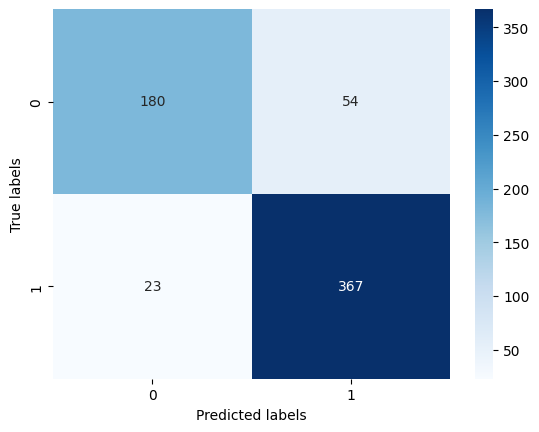

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix as heatmap
sns.heatmap(confusion_Matrix, annot=True, cmap='Blues',fmt='.3g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


# graph between the training and validation accuracy and loss

In [57]:
history

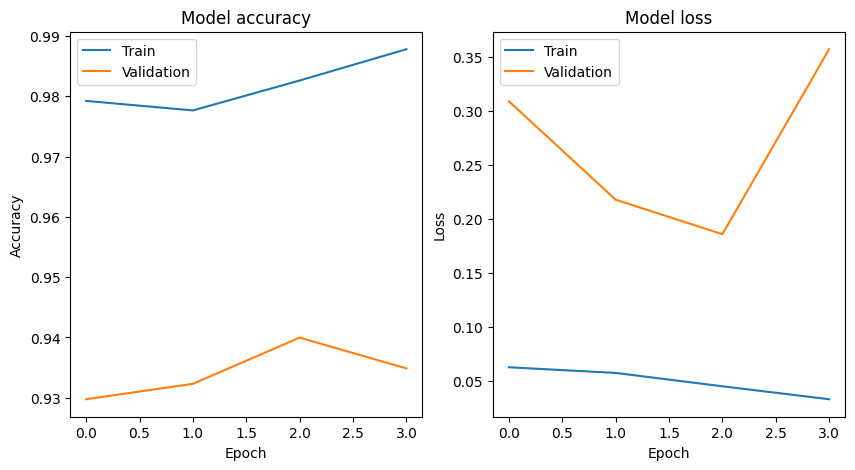

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# Plot the training and validation accuracy
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot the training and validation loss
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

# Display the plots
plt.show()

# Classification Report

In [72]:
y_pred_binary = np.squeeze(np.round(y_pred))
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.89      0.77      0.82       234
           1       0.87      0.94      0.91       390

    accuracy                           0.88       624
   macro avg       0.88      0.86      0.86       624
weighted avg       0.88      0.88      0.87       624



# AUC curve for binary classification

20/20 [==============================] - 0s 12ms/step


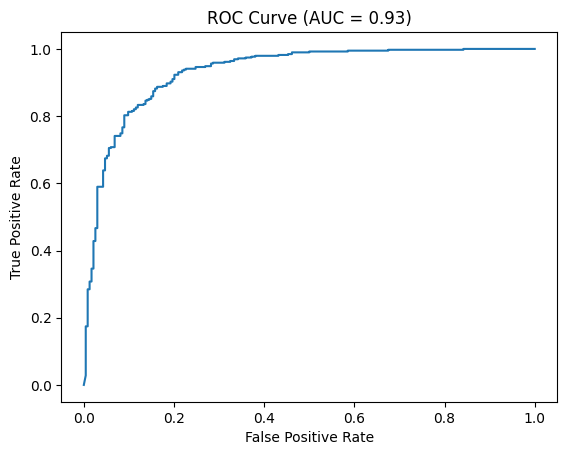

In [46]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get the predicted probabilities for the positive class
y_prob = model.predict(x_test)

# Compute the FPR, TPR, and thresholds for various classification thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute the AUC score
auc_score = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {auc_score:.2f})')
plt.show()


# Save the model

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#save my model in google drive
# model.save('/content/drive/MyDrive/xray_model/xRay_model_binary 2 8.h5')

# Load Model and Test

In [50]:
modelLoaded = load_model('/content/drive/MyDrive/xray_model/xRay_model_binary 2 8.h5')

In [53]:
def predictImg():
    fig, axs = plt.subplots(2, 5, figsize=(10, 4))
    axs = axs.flatten()
    
    for i in range(10):
        testimgnum = i+30
        predicted = modelLoaded.predict(np.array([x_test[testimgnum]]))
        predicted = int(np.round(predicted))
        predictedClass = int(predicted >= 0.5)
        actual = y_test[testimgnum]
        
        axs[i].imshow(x_test[testimgnum], cmap='gray')
        axs[i].set_title(f'Predicted: {classnames[predictedClass]} \nActual: {classnames[actual]}')
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()


1/1 [==============================] - 0s 28ms/step


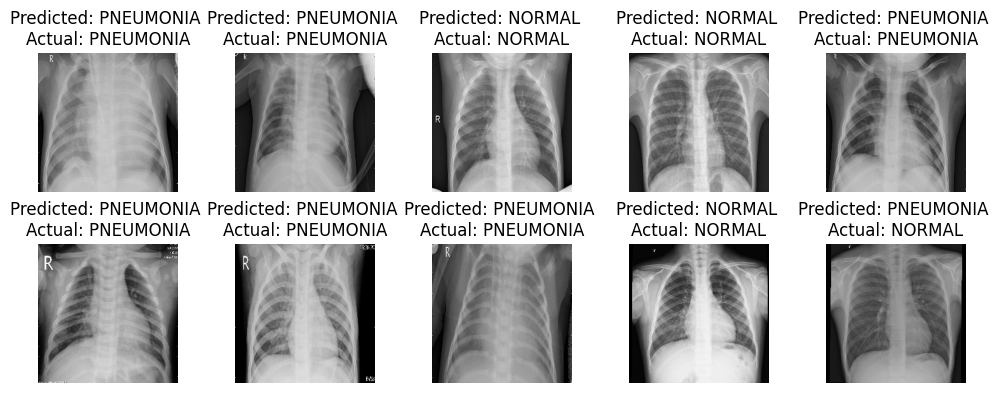

In [54]:
predictImg()